**Description**: Simulation experiment for [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/a/614033/337906). This
experiment demonstrates that training PCA on test set features (no labels) is not okay
if the features are not rank-one.

**Estimated runtime**: 1 min.

**Required packages**:
```
matplotlib>=3.4.3
scikit-learn>=0.24.2
tqdm>=4.62.3
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Set simluation parameters

These are for generating data from a linear model, where features can be correlated with
each other.

In [2]:
NUM_TRIALS = 300

# sample sizes
NUM_TRAIN_OBS = 100  # obs to train linear regression on
NUM_TEST_OBS = list(range(25, 525, 25))  # also the # of obs to fit PCA  

# features
NUM_FEATURES = 20              # keep in mind the number of train and test obs
NUM_FEATURES_INFORMATIVE = 10      # <= NUM_FEATURES
EFFECTIVE_RANKS = [5, 10, 15, 20]  # <= NUM_FEATURES
NUM_PCA_COMPONENTS = [int(0.6 * effective_rank) for effective_rank in EFFECTIVE_RANKS]

# seeds
RANDOM_STATE_GENERATE_DATA = 123
RANDOM_STATE_SPLIT_DATA = 42

# labels
NOISE_ST_DEV = 1.0

## Run simulations

In [3]:
def _split(
    X: np.ndarray,
    y: np.ndarray,
    num_test: int,
    num_train: int = NUM_TRAIN_OBS,
    random_state: int = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, train_size=num_train, random_state=random_state
    )
    random_state = None if random_state is None else random_state + 1
    X_ex, X_te, y_ex, y_te = train_test_split(
        X_te, y_te, train_size=num_test, test_size=num_test, random_state=random_state
    )
    return (X_tr, X_ex, X_te, y_tr, y_ex, y_te)

In [4]:
def _simulation(
    X: np.ndarray,
    y: np.ndarray,
    num_test: int,
    num_pca_components: int,
    num_trials: int = NUM_TRIALS,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    rmses_ba: list[float] = []
    rmses_ex: list[float] = []
    rmses_te: list[float] = []

    for i in range(num_trials):
        X_tr, X_ex, X_te, y_tr, _, y_te = _split(
            X, y, num_test=num_test, random_state=RANDOM_STATE_SPLIT_DATA + i
        )

        def rmse(X_for_fitting_pca: np.ndarray) -> float:
            pca = PCA(n_components=num_pca_components).fit(X_for_fitting_pca)
            X_tr_reduced = pca.transform(X_tr)
            model = LinearRegression().fit(X_tr_reduced, y_tr)
            # score the model on test
            X_te_reduced = pca.transform(X_te)
            y_te_pred = model.predict(X_te_reduced)
            return np.sqrt(np.mean((y_te_pred - y_te) ** 2))

        def base(X_tr: np.ndarray) -> float:
            model = LinearRegression().fit(X_tr, y_tr)
            y_te_pred = model.predict(X_te)
            return np.sqrt(np.mean((y_te_pred - y_te) ** 2))

        rmses_ba.append(base(X_tr))
        rmses_ex.append(rmse(X_ex))
        rmses_te.append(rmse(X_te))

    return np.array(rmses_ba), np.array(rmses_ex), np.array(rmses_te)


def simulation(effective_rank: int, num_pca_components: int):
    rmses_ba = []
    rmses_ex = []
    rmses_te = []
    for num_test in tqdm(NUM_TEST_OBS):
        X, y = make_regression(
            n_samples=NUM_TRAIN_OBS + num_test + num_test,
            n_features=NUM_FEATURES,
            n_informative=NUM_FEATURES_INFORMATIVE,
            effective_rank=effective_rank,
            noise=NOISE_ST_DEV,
            random_state=RANDOM_STATE_GENERATE_DATA,
        )
        _rmses_base, _rmses_ex, _rmses_te = _simulation(
            X, y, num_test, num_pca_components
        )
        rmses_ba.append(_rmses_base)
        rmses_ex.append(_rmses_ex)
        rmses_te.append(_rmses_te)
    return np.array(rmses_ba), np.array(rmses_ex), np.array(rmses_te)

In [5]:
paired_diffs_boost: list[np.ndarray] = []
standard_errors_boost: list[np.ndarray] = []

paired_diffs_bias: list[np.ndarray] = []
standard_errors_bias: list[np.ndarray] = []

for i in tqdm(range(len(EFFECTIVE_RANKS)), desc="Simulation"):
    rmses_ba, rmses_ex, rmses_te = simulation(EFFECTIVE_RANKS[i], NUM_PCA_COMPONENTS[i])

    paired_diffs: np.ndarray = rmses_ba - rmses_ex
    standard_errors = np.sqrt(np.var(paired_diffs, axis=1, ddof=1) / rmses_ex.shape[1])
    paired_diffs_boost.append(paired_diffs)
    standard_errors_boost.append(standard_errors)

    paired_diffs: np.ndarray = rmses_ex - rmses_te
    standard_errors = np.sqrt(np.var(paired_diffs, axis=1, ddof=1) / rmses_ex.shape[1])
    paired_diffs_bias.append(paired_diffs)
    standard_errors_bias.append(standard_errors)

Simulation:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
def plot_error_bars(means: np.ndarray, ses: np.ndarray, ylabel: str):
    plt.figure(figsize=(10, 5))
    for i in reversed(range(len(EFFECTIVE_RANKS))):
        plt.errorbar(
            x=NUM_TEST_OBS,
            y=np.mean(means[i], axis=1),
            yerr=1.96 * ses[i],
            capsize=3,
            label=(
                f"rank = {EFFECTIVE_RANKS[i]}, {'  ' if EFFECTIVE_RANKS[i] < 10 else ''}"
                f"PCA components = {NUM_PCA_COMPONENTS[i]}"
            ),
        )
    plt.xlabel("# PCA training observations")
    plt.ylabel(ylabel)
    plt.title(
        f"# features = {NUM_FEATURES}, "
        f"$\sigma$ = {NOISE_ST_DEV} "
        "(w/ 95% CI paired difference)"
    )
    np.arange(0, max(NUM_TEST_OBS)+50, step=50)
    plt.grid()
    plt.legend()

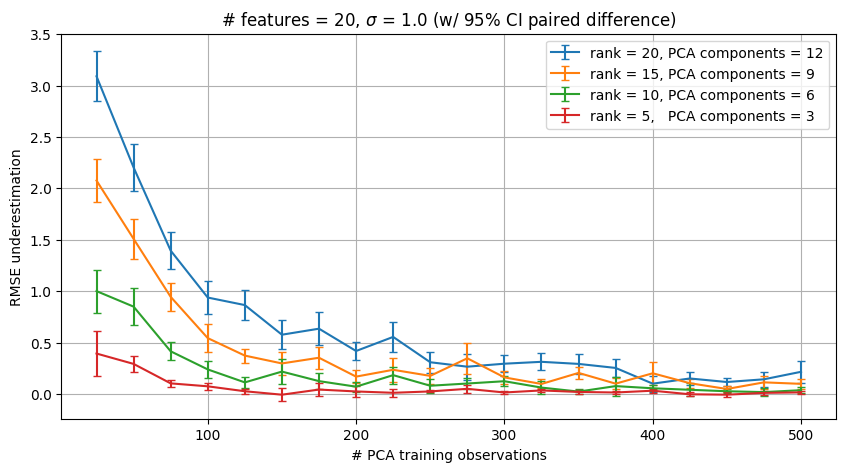

In [7]:
plot_error_bars(paired_diffs_bias, standard_errors_bias, ylabel="RMSE underestimation")

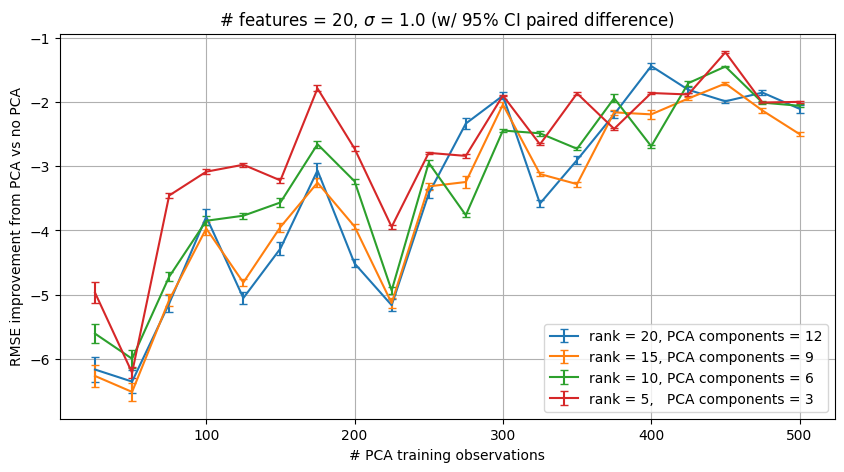

In [9]:
plot_error_bars(
    paired_diffs_boost,
    standard_errors_boost,
    ylabel="RMSE improvement from PCA vs no PCA",
)  # PCA hurts